In [1]:
# Code from pyro tutorial

!pip install pyro-ppl 

import torch
import torch.distributions as distributions

import pyro

pyro.set_rng_seed(101)

# Main assumption going forward: Any event can be represented as a (torch) distribution!

---



In [2]:
# Just using torch distributions (no pyro yet)
mu = 0
sigma = 1

normal = distributions.Normal(mu, sigma)
x = normal.rsample() # draw a sample from N(0, 1)
print("sample:", x)
print("log prob:", normal.log_prob(x))

sample: tensor(-1.3905)
log prob: tensor(-1.8857)


In [0]:
# weather model (still only using torch)
def weather():
  is_cloudy = distributions.Bernoulli(0.3).sample()
  is_cloudy = 'cloudy' if is_cloudy.item() == 1.0 else 'sunny'
  mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[is_cloudy]
  scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[is_cloudy]
  temp = distributions.Normal(mean_temp, scale_temp).rsample()
  return is_cloudy, temp.item()

In [4]:
# Now using pyro.
"""
Pyro uses names for each sample since these names are used to uniquely identify 
sample statements and change behavior at runtime depending on how the enclosing 
stochastic function is being used.
"""
x = pyro.sample("first_sample", pyro.distributions.Normal(mu, sigma))
x

tensor(-0.8152)

In [0]:
# joint distribution of a bernoulli rv and a normal rv
def pyro_weather():
  is_cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
  is_cloudy = 'cloudy' if is_cloudy.item() == 1.0 else 'sunny'
  mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[is_cloudy]
  scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[is_cloudy]
  temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
  return is_cloudy, temp.item()

In [6]:
# weather sampling
for _ in range(5):
  print(pyro_weather())

('cloudy', 64.5440444946289)
('sunny', 94.37557983398438)
('sunny', 72.5186767578125)
('cloudy', 54.18292999267578)
('sunny', 93.99440002441406)


In [7]:
# now build a more complicated model using the past simple weather model
def ice_cream_sales():
  cloudy, temp = pyro_weather()
  expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
  ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.))
  return ice_cream

for _ in range(5):
  print(ice_cream_sales())

tensor(206.0483)
tensor(51.5489)
tensor(52.4866)
tensor(21.4417)
tensor(42.9951)


In [8]:
# recursive geometric distribution
def geometric(p, t=0):
  x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
  if x.item() == 1:
    return 0
  else:
    return 1 + geometric(p, t + 1)

geometric(0.5)

0

In [9]:
# higher-order functionality
def normal_product(loc, scale):
  z1 = pyro.sample('z1', pyro.distributions.Normal(loc, scale))
  z2 = pyro.sample('z2', pyro.distributions.Normal(loc, scale))
  y = z1 * z2
  return y

def make_normal_normal():
  mu_latent = pyro.sample('mu_latent', pyro.distributions.Normal(0, 1))
  fn = lambda scale: normal_product(mu_latent, scale)
  return fn

print(make_normal_normal()(1.))

tensor(-0.1305)


## Pyro stochastic functions are *universal*, which means that they can be used to represent any computable probability distribution!

In [10]:
!pip install pyro-ppl

import matplotlib.pyplot as plt

import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

%matplotlib inline

pyro.set_rng_seed(101)

In [0]:
# weight | guess ~ N(guess, 1), measurement | guess, weight ~ N(weight, .75)

def scale(guess):
  weight = pyro.sample("weight", dist.Normal(guess, 1))
  return pyro.sample("measurement", dist.Normal(weight, .75))

In [0]:
# Want to model (weight | guess, measurement = 9.5)
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

In [0]:
def deferred_conditioned_scale(measurement, guess):
  return pyro.condition(scale, data={'measurement': measurement})(guess)

In [0]:
def scale_obs(guess): # equivalent to conditioned_scale above
  weight = pyro.sample('weight', dist.Normal(guess, 1.))
  return pyro.sample('measurement', dist.Normal(weight, 1.), obs=9.5)

In [0]:
def perfect_guide(guess):
  loc = (0.75 ** 2 * guess + 9.5) / (1 + 0.75 ** 2) # 9.14
  scale = np.sqrt(0.75 ** 2 / (1 + 0.75 ** 2)) # 0.6
  return pyro.sample('weight', dist.Normal(loc, scale))

## Pyro Variational Inference: Use the top-level function `pyro.param` to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation according to some loss function.

In [0]:
from torch.distributions import constraints

def scale_parameterized_guide(guess):
  a = pyro.param('a', torch.tensor(guess))
  # make positive since std must be positive
  b = pyro.param('b', torch.tensor(1.), constraint=constraints.positive)
  return pyro.sample('weight', dist.Normal(a, b))

Stochastic Variational Inference (SVI) is a powerful and widely applicable class of variational inference algorithms with three key characteristics:

1. Parameters are always real-valued tensors
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide
3. We use stochastic gradient descent to search for the optimal parameters.

a =  9.107148170471191
b =  0.6064099669456482


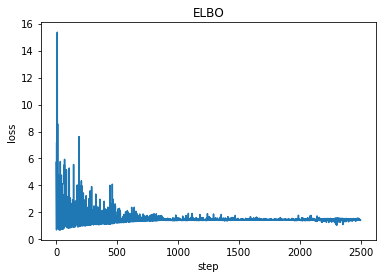

In [17]:
# simple SVI example

guess = 8.5
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parameterized_guide,
                     optim=pyro.optim.SGD({'lr': 0.001, 'momentum': 0.1}),
                     loss=pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
  losses.append(svi.step(guess))
  a.append(pyro.param('a').item())
  b.append(pyro.param('b').item())
  
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

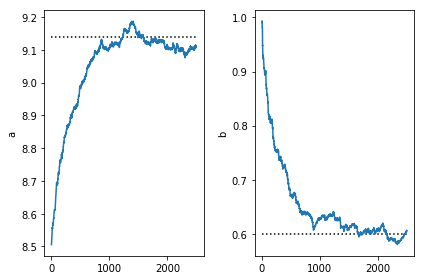

In [18]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()